In [ ]:
import numpy
# scipy.special for the sigmoid function expit()
import scipy.special
# helper to load data from PNG image files
import imageio
# library for plotting arrays
import matplotlib.pyplot
# ensure the plots are inside this notebook, not an external window
%matplotlib inline
#for normalizing activation derivatives that are not sigmoid
from sklearn.preprocessing import normalize
from scipy.special import softmax

def relu(z):
    return (z > 0).astype(int)

def d_relu(x):
    return numpy.heaviside(x, 1)

def m_tanh(x):
    return numpy.tanh(x)

def d_tanh(x):
    return 1.0 - x**2

def derive(function, value):
    h = 0.00000000001
    top = function(value + h) - function(value)
    bottom = h
    slope = top / bottom
    # Returns the slope to the third decimal
    return float("%.3f" % slope)

# neural network class definition
class neuralNetwork:
  # initialise the neural network
  def __init__(self, inputnodes, hiddennodes, outputnodes, learningrate):
    # set number of nodes in each input, hidden, output layer
    self.inodes = inputnodes
    self.hnodes = hiddennodes
    self.onodes = outputnodes
    
    # link weight matrices, wih and who
    # weights inside the arrays are w_i_j, where link is from node i to node j in the next layer
    # w11 w21
    # w12 w22 etc 
    self.wih = numpy.random.normal(0.0, pow(self.inodes, -0.5), (self.hnodes, self.inodes))
    self.who = numpy.random.normal(0.0, pow(self.hnodes, -0.5), (self.onodes, self.hnodes))

    # learning rate
    self.lr = learningrate

    pass

  def activation_function(self, x):
    return scipy.special.expit(x)
    #return numpy.tanh(x)

  # train the neural network
  def train(self, inputs_list, targets_list):
    # convert inputs list to 2d array
    inputs = numpy.array(inputs_list, ndmin=2).T
    targets = numpy.array(targets_list, ndmin=2).T
    
    # calculate signals into hidden layer
    hidden_inputs = numpy.dot(self.wih, inputs)
    # calculate the signals emerging from hidden layer
    hidden_outputs = self.activation_function(hidden_inputs)
    
    # calculate signals into final output layer
    final_inputs = numpy.dot(self.who, hidden_outputs)
    # calculate the signals emerging from final output layer
    final_outputs = self.activation_function(final_inputs)
    
    # output layer error is the (target - actual)
    output_errors = targets - final_outputs
    # hidden layer error is the output_errors, split by weights, recombined at hidden nodes
    hidden_errors = numpy.dot(self.who.T, output_errors) 
    
    #These both use the derivative of the sigmoid function like on page 140 of the book.
    #So they would need to be changed with a different activation function

    # update the weights for the links between the hidden and output layers
    self.who += self.lr * numpy.dot((output_errors * final_outputs * (1.0 - final_outputs)), numpy.transpose(hidden_outputs))
    #self.who += self.lr * numpy.dot((output_errors * (1.0 - final_outputs**2)), numpy.transpose(hidden_outputs))
    
    # update the weights for the links between the input and hidden layers
    self.wih += self.lr * numpy.dot((hidden_errors * hidden_outputs * (1.0 - hidden_outputs)), numpy.transpose(inputs))
    #self.wih += self.lr * numpy.dot((hidden_errors * (1.0 - hidden_outputs**2)), numpy.transpose(inputs))
    
    pass
    
  # query the neural network
  def query(self, inputs_list):
    # convert inputs list to 2d array
    inputs = numpy.array(inputs_list, ndmin=2).T
    
    # calculate signals into hidden layer
    hidden_inputs = numpy.dot(self.wih, inputs)
    # calculate the signals emerging from hidden layer
    hidden_outputs = self.activation_function(hidden_inputs)
    
    # calculate signals into final output layer
    final_inputs = numpy.dot(self.who, hidden_outputs)
    # calculate the signals emerging from final output layer
    final_outputs = self.activation_function(final_inputs)
    
    return final_outputs

In [ ]:
# number of input, hidden and output nodes
input_nodes = 784
hidden_nodes = 200
output_nodes = 10

# learning rate
learning_rate = 0.05

# create instance of neural network
n = neuralNetwork(input_nodes,hidden_nodes,output_nodes, learning_rate)

In [ ]:
# load the mnist training data CSV file into a list
training_data_file = open("sample_data/mnist_train_small.csv", 'r')
training_data_list = training_data_file.readlines()
training_data_file.close()
print("mnist training data loaded")

mnist training data loaded


In [ ]:
# train the neural network

# epochs is the number of times the training data set is used for training
epochs = 20

for e in range(epochs):
    print("starting epoch {}".format(e))
    # go through all records in the training data set
    for record in training_data_list:
        # split the record by the ',' commas
        all_values = record.split(',')
        # scale and shift the inputs
        inputs = (numpy.asfarray(all_values[1:]) / 255.0 * 0.99) + 0.01
        # create the target output values (all 0.01, except the desired label which is 0.99)
        targets = numpy.zeros(output_nodes) + 0.01
        # all_values[0] is the target label for this record
        targets[int(all_values[0])] = 0.99
        n.train(inputs, targets)
        pass
    pass

starting epoch 0
starting epoch 1
starting epoch 2
starting epoch 3
starting epoch 4
starting epoch 5
starting epoch 6
starting epoch 7
starting epoch 8
starting epoch 9
starting epoch 10
starting epoch 11
starting epoch 12
starting epoch 13
starting epoch 14
starting epoch 15
starting epoch 16
starting epoch 17
starting epoch 18
starting epoch 19


In [ ]:
with open('sample_data/model.npy', 'wb') as f:
  numpy.save(f, n.wih)
  numpy.save(f, n.who)

In [ ]:
# load the mnist test data CSV file into a list
test_data_file = open("sample_data/mnist_test.csv", 'r')
test_data_list = test_data_file.readlines()
test_data_file.close()
print("mnist testing data loaded")

mnist testing data loaded


In [ ]:
# test the neural network
print("testing neural network for precision")

# scorecard for how well the network performs, initially empty
scorecard = []

# go through all the records in the test data set
for record in test_data_list:
    # split the record by the ',' commas
    all_values = record.split(',')
    # correct answer is first value
    correct_label = int(all_values[0])
    # scale and shift the inputs
    inputs = (numpy.asfarray(all_values[1:]) / 255.0 * 0.99) + 0.01
    # query the network
    outputs = n.query(inputs)
    # the index of the highest value corresponds to the label
    label = numpy.argmax(outputs)
    # append correct or incorrect to list
    if (label == correct_label):
        # network's answer matches correct answer, add 1 to scorecard
        scorecard.append(1)
    else:
        # network's answer doesn't match correct answer, add 0 to scorecard
        scorecard.append(0)
        pass
    
    pass

testing neural network for precision


In [ ]:
# calculate the performance score, the fraction of correct answers
scorecard_array = numpy.asarray(scorecard)
print ("performance = ", scorecard_array.sum() / scorecard_array.size)

performance =  0.9715


loading ... myimage.png
min =  0.01
max =  1.0
[[1.01792362e-03]
 [1.32183603e-03]
 [9.47891784e-01]
 [3.91937326e-03]
 [6.04021002e-03]
 [9.08990453e-04]
 [6.88512308e-02]
 [2.39007753e-03]
 [6.93524992e-02]
 [8.75730253e-04]]
Network predition:  2


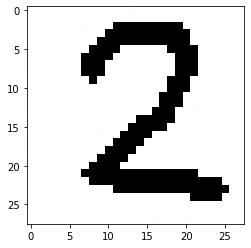

In [ ]:
# test the neural network with our own images

# load image data from png files into an array
print ("loading ... myimage.png")
img_array = imageio.imread('myimage.jpg', as_gray=True)
    
# reshape from 28x28 to list of 784 values, invert values
img_data  = 255.0 - img_array.reshape(784)
    
# then scale data to range from 0.01 to 1.0
img_data = (img_data / 255.0 * 0.99) + 0.01
print("min = ", numpy.min(img_data))
print("max = ", numpy.max(img_data))

# plot image
matplotlib.pyplot.imshow(img_data.reshape(28,28), cmap='Greys', interpolation='None')

# query the network
outputs = n.query(img_data)
print (outputs)

# the index of the highest value corresponds to the label
label = numpy.argmax(outputs)
print("Network predition: ", label)

Below is the deployment network which takes a pretrained model and predicts outputs

In [ ]:
# neural network class definition
class neuralNetworkDeploy:
  # initialise the neural network
  def __init__(self, inputnodes, hiddennodes, outputnodes, wih, who):
    # set number of nodes in each input, hidden, output layer
    self.inodes = inputnodes
    self.hnodes = hiddennodes
    self.onodes = outputnodes
    
    # link weight matrices, wih and who
    # weights inside the arrays are w_i_j, where link is from node i to node j in the next layer
    # w11 w21
    # w12 w22 etc 
    self.wih = wih
    self.who = who

    pass

  def activation_function(self, x):
    return scipy.special.expit(x)
    
  # query the neural network
  def query(self, inputs_list):
    # convert inputs list to 2d array
    inputs = numpy.array(inputs_list, ndmin=2).T
    
    # calculate signals into hidden layer
    hidden_inputs = numpy.dot(self.wih, inputs)
    # calculate the signals emerging from hidden layer
    hidden_outputs = self.activation_function(hidden_inputs)
    
    # calculate signals into final output layer
    final_inputs = numpy.dot(self.who, hidden_outputs)
    # calculate the signals emerging from final output layer
    final_outputs = self.activation_function(final_inputs)
    
    return final_outputs

In [ ]:
# number of input, hidden and output nodes
input_nodes = 784
hidden_nodes = 200
output_nodes = 10

with open('sample_data/model.npy', 'rb') as f:
    wih = numpy.load(f)
    who = numpy.load(f)

# create instance of neural network
net = neuralNetworkDeploy(input_nodes, hidden_nodes, output_nodes, wih, who)

loading ... myimage.png
min =  0.01
max =  1.0
[[1.01792362e-03]
 [1.32183603e-03]
 [9.47891784e-01]
 [3.91937326e-03]
 [6.04021002e-03]
 [9.08990453e-04]
 [6.88512308e-02]
 [2.39007753e-03]
 [6.93524992e-02]
 [8.75730253e-04]]
Network predition:  2


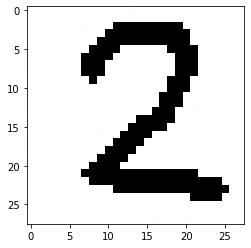

In [ ]:
# test the neural network with our own images

# load image data from png files into an array
print ("loading ... myimage.png")
img_array = imageio.imread('myimage.jpg', as_gray=True)
    
# reshape from 28x28 to list of 784 values, invert values
img_data  = 255.0 - img_array.reshape(784)
    
# then scale data to range from 0.01 to 1.0
img_data = (img_data / 255.0 * 0.99) + 0.01
print("min = ", numpy.min(img_data))
print("max = ", numpy.max(img_data))

# plot image
matplotlib.pyplot.imshow(img_data.reshape(28,28), cmap='Greys', interpolation='None')

# query the network
outputs = net.query(img_data)
print (outputs)

# the index of the highest value corresponds to the label
label = numpy.argmax(outputs)
print("Network predition: ", label)